In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc, plot_lift_curve
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

2-d

In [73]:
actual = [1,1,1,0,1,0,1,0,0,0]
FPR = [0]
TPR = [0]
p = sum(actual)
n = len(actual) - p

Text(0.5, 1.0, 'ROC Curve')

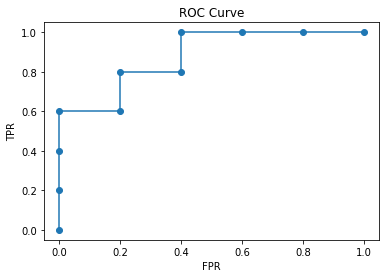

In [13]:
for i in range(len(actual)):
    if actual[i] == 1:
        FPR.append(FPR[i])
        TPR.append(TPR[i]+(1/p))
    else:
        FPR.append(FPR[i]+(1/n))
        TPR.append(TPR[i])
plt.plot(FPR, TPR, marker = 'o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

2-e

In [77]:
# FPC1, FNC1, FPC2, FNC2, FPC3, FNC3 = 1, 1, 2, 1, 1, 2
pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
i1, i2, i3 = 0, 0, 0
cm = confusion_matrix(actual, pred)
# misses = cm[0][1] + cm[1][0]
# misses is actually the total number of cases
misses = 10
c1 = (cm[0][1] + cm[1][0])/misses
c2 = (2*cm[0][1] + cm[1][0])/misses
c3 = (cm[0][1] + 2*cm[1][0])/misses
# c1, c2, c3 = 0, 0, 0
for i in range(len(actual)):
    pred[i]=1
    cm = confusion_matrix(actual, pred)
    # misses = cm[0][1] + cm[1][0]
    c1t = (cm[0][1] + cm[1][0])/misses
    c2t = (2*cm[0][1] + cm[1][0])/misses
    c3t = (cm[0][1] + 2*cm[1][0])/misses
    if c1t < c1: 
        c1 = c1t
        i1 = i+1
    if c2t < c2: 
        c2 = c2t
        i2 = i+1
    if c3t < c3: 
        c3 = c3t
        i3 = i+1
i1, i2, i3, c1, c2, c3

(3, 3, 7, 0.2, 0.2, 0.2)

4

Reading the data and encoding the B and M label values as 0 and 1

In [17]:
X = pd.read_csv('../data/wdbc.data', header=None, usecols=range(1,32))
Y = X[1]
X.drop([1], axis = 1, inplace=True)
le = LabelEncoder()
Y=le.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 29, stratify = Y)

Setting up the classifiers and gridSearch for inner loops

In [35]:
complexity_values = range(1,10)

clf1 = DecisionTreeClassifier()
p_grid1 = [{'max_depth': complexity_values, 'criterion': ['gini', 'entropy']}]

clf2 = KNeighborsClassifier()
pipe2 = Pipeline([('std', StandardScaler()), ('clf2', clf2)])
p_grid2 = [{'clf2__n_neighbors': complexity_values}]

# For small datasets, ‘liblinear’ is a good choice for solver
clf3 = LogisticRegression(solver='liblinear')
pipe3 = Pipeline([('std', StandardScaler()), ('clf3', clf3)])
p_grid3 = [{'clf3__C': np.power(10, range(0,10))}]

clf4 = SVC()
pipe4 = Pipeline([('std', StandardScaler()), ('clf4', clf4)])
p_grid4 = [{'clf4__kernel': ['rbf'], 'clf4__C': np.power(10, range(0,5)), 'clf4__gamma': np.power(10., range(-5,0))},
        {'clf4__kernel': ['linear'], 'clf4__C': np.power(10, range(0,5))}]


inner_cv = StratifiedKFold(n_splits=4, shuffle=True)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True)
grid_cv = []

# Recall is chosen for scoring because falsely classifying true malignant case as benign is dangerous/costly
for p_grid, est in zip((p_grid1, p_grid2, p_grid3, p_grid4), (clf1, pipe2, pipe3, pipe4)):
    gs = GridSearchCV(estimator=est, param_grid=p_grid, scoring='recall', cv=inner_cv)
    grid_cv.append(gs)


Running the nested-cv and getting the mean and standard deviation of the scores for each of the 4 models

In [40]:
nested_scores = []
for gs in grid_cv:
    nested_score = cross_val_score(gs, X=x_train, y=y_train, cv=outer_cv, scoring='recall')
    nested_scores.append((nested_score.mean(), nested_score.std()))

nested_scores

[(0.9170819490586932, 0.049454652439858755),
 (0.9173588039867109, 0.05411274580352311),
 (0.946705426356589, 0.035264787012444565),
 (0.9350775193798448, 0.038619773962432886)]

From the nested-cv, the best model seems to be the 3rd one - Logistic Regression<br>
Find the best hyper-parameters for the logistic model and retrain on the whole train set

In [49]:
hp_model = GridSearchCV(estimator=pipe3, param_grid=p_grid3, scoring='recall', cv=inner_cv)
hp_model.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf3',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'clf3__C': array([         1,         10,        100,       1000,      10000,
           100000,    1000000,   10000000,  100000000, 1000000000],
      dtype=int32)}],
             scoring='recall')

In [66]:
best_model = hp_model.best_estimator_
pred = best_model.predict(pd.DataFrame(x_test))
print(confusion_matrix(y_test, pred))
print(recall_score(y_test, pred))
print(accuracy_score(y_test, pred))
prob = best_model.predict_proba(pd.DataFrame(x_test))

[[72  0]
 [ 0 42]]
1.0
1.0


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

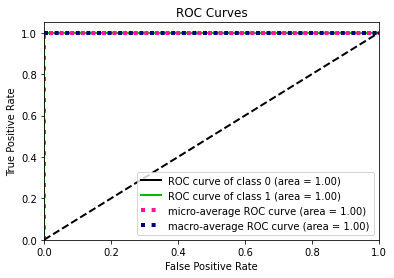

In [65]:
plot_roc(y_test, prob)

The model is not making any errors on the test data and <br>
hence the ROC curve is perfect with an AUC of 1 

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

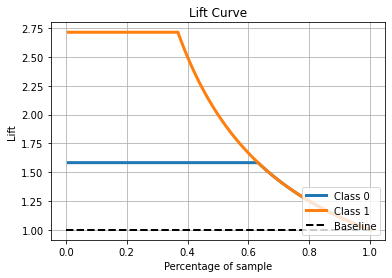

In [67]:
plot_lift_curve(y_test, prob)

In [86]:
pd.DataFrame(prob).sort_values(by=1)

,0,1
88,4.921627e-01,0.507837
78,2.472086e-01,0.752791
96,1.739312e-01,0.826069
49,1.062852e-01,0.893715
76,1.018133e-01,0.898187
...,...,...
86,8.440875e-10,1.000000
106,3.257328e-11,1.000000
89,3.091083e-12,1.000000
1,1.055378e-12,1.000000


The lift curve for class 1 is horizontal until almost 0.4 percentage of sample <br>
This is happening because the model is predicting a probability of 1 for those samples <br>
Also, the curve for class 1 is higher than 0. This is what we want because <br> 
we want to be able to classify 1 class (malignant) better